# Predicting Market Value of a Car

# Content

* [Introduction](#intro)
* [Initialization](#initlization)
* [Data Exploration](#data_exploration)
* [Data Preprocessing](#data_preprocessing)
	* [Conclusion](#conclusion)
* [Exploratory Data Analysis (EDA)](#eda)
	* [Conclusion](#conclusion)
* [Training Models](#training_models)
	* [Linear Regression for Sanity Check](#sanity_check)
	* [Random Forest Regressor](#random_forest)
	* [LightGBM Regressor](#lightGBM)
	* [CatBoost Regressor](#catboost)
	* [XGBoost](#xgboost)
	* [Conclusion](#conclusion)
* [Model Analysis](model_analysis)
	* [Conclusion](#conclusion)
* [Findings](#findings)
	


## Introduction 

Rusty Bargain, a used car sales service, wants to develop an app is attract new customers. In that app, we should be able to quickly find out the market value of a car. We have access to historical data: technical specifications, trim versions, and prices. We need to build a model to determine the value. 

Rusty Bargain is interested in:
* the quality of the prediction 
* the speed of the prediction 
* the time required for training 

**Data Description:**

**Features**
* `DateCrawled` — date profile was downloaded from the database
* `VehicleType` — vehicle body type
* `RegistrationYear` — vehicle registration year
* `Gearbox` — gearbox type
* `Power` — power (hp)
* `Model` — vehicle model
* `Mileage` — mileage (measured in km due to dataset's regional specifics)
* `RegistrationMonth` — vehicle registration month
* `FuelType` — fuel type
* `Brand` — vehicle brand
* `NotRepaired` — vehicle repaired or not
* `DateCreated` — date of profile creation
* `NumberOfPictures` — number of vehicle pictures
* `PostalCode` — postal code of profile owner (user)
* `LastSeen` — date of the last activity of the user

**Target** 
* `Price` - price (Euro)

**Objectives:**
* Train different models with various hyperparameters 
* Use RMSE metric to evaluate the models
* Compare gradient boosting methods with random forest, decision tree, and linear regression
* Analyze the speed and quality of the models

## Initialization

In [1]:
# Loading all libraries
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 76.6 MB 57 kB/s 


In [2]:
# Loading the data
try:
  df = pd.read_csv('car_data.csv')
except:
  df = pd.read_csv('/datasets/car_data.csv')

## Data Exploration

Description of data:

* `DateCrawled` — date profile was downloaded from the database
* `VehicleType` — vehicle body type
* `RegistrationYear` — vehicle registration year
* `Gearbox` — gearbox type
* `Power` — power (hp)
* `Model` — vehicle model
* `Mileage` — mileage (measured in km due to dataset's regional specifics)
* `RegistrationMonth` — vehicle registration month
* `FuelType` — fuel type
* `Brand` — vehicle brand
* `NotRepaired` — vehicle repaired or not
* `DateCreated` — date of profile creation
* `NumberOfPictures` — number of vehicle pictures
* `PostalCode` — postal code of profile owner (user)
* `LastSeen` — date of the last activity of the user
* `Price` - price (Euro)

In [3]:
# Obtaining first five rows of table
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# Obtaining number of rows and columns 
shape = df.shape
print('The table has {} rows and {} columns'.format(shape[0], shape[1]))

The table has 354369 rows and 16 columns


In [5]:
# Obtaining general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Since there are 354,369 rows per column, df contains missing values in columns `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired`.

In [6]:
# Percentage of missing values per column 
df_mis = df.isna().sum().to_frame('missing_values')
df_mis['%'] = round(100 * df.isna().sum()/len(df), 3)
print(df_mis.sort_values(by='%', ascending=False))

                   missing_values       %
NotRepaired                 71154  20.079
VehicleType                 37490  10.579
FuelType                    32895   9.283
Gearbox                     19833   5.597
Model                       19705   5.561
DateCrawled                     0   0.000
Price                           0   0.000
RegistrationYear                0   0.000
Power                           0   0.000
Mileage                         0   0.000
RegistrationMonth               0   0.000
Brand                           0   0.000
DateCreated                     0   0.000
NumberOfPictures                0   0.000
PostalCode                      0   0.000
LastSeen                        0   0.000


In [7]:
# Checking for duplicates
df.duplicated().sum()

262

There are 262 duplicated values in our data. 

### Conclusion

Our dataset contains 354,369 rows and 16 columns. There are missing values in the columns `VehicleType`, `Gearbox`, `Model`, `FuelType`, and `NotRepaired`. The dataframe also contains duplicated data. Column names don't follow good rules of style and date values are written as object type. 

We will now preprocess our data to deal with missing values and duplicates. We will also fix column names and change datatype to make our data easier to work with.

## Data Preprocessing

In [8]:
# Chaning column names to lowercase
df.columns = df.columns.str.lower()

# Renaming columns
df = df.rename(columns={'datecrawled':'date_crawled', 'vehicletype':'vehicle_type', 'registrationyear':'registration_year', 'registrationmonth': 'registration_month', 
                        'fueltype':'fuel_type', 'notrepaired': 'not_repaired', 'datecreated': 'date_created', 
                        'numberofpictures': 'number_of_pictures', 'postalcode': 'postal_code', 'lastseen': 'last_seen'})

# Checking to see if columns have been properly renamed
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')

In [9]:
# Converting datatype
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['date_created'] = pd.to_datetime(df['date_created'], format='%d/%m/%Y %H:%M')
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%d/%m/%Y %H:%M')

#Checking to see if columns have been properly converted
df.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
mileage                        int64
registration_month             int64
fuel_type                     object
brand                         object
not_repaired                  object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

In [10]:
# Obtaining number of missing values per column
df.isna().sum().sort_values(ascending=False)

not_repaired          71154
vehicle_type          37490
fuel_type             32895
gearbox               19833
model                 19705
date_crawled              0
price                     0
registration_year         0
power                     0
mileage                   0
registration_month        0
brand                     0
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [11]:
# Percent of missing value in not_repaired
mis = df['not_repaired'].isna().sum()/len(df)
print(f'Percent of missing values in not_repaired: {mis:.3%}')

Percent of missing values in not_repaired: 20.079%


Since there is such a large percentage of missing values, we cannot drop the missing values in this column. 

In [12]:
# Obtaining unique values for not_repaired 
print(df['not_repaired'].unique())

[nan 'yes' 'no']


Since we don't know whether the car has been repaired, we will fill missing values with "unknown." 

In [13]:
# Filling in missing values with "unknown"
df['not_repaired'].fillna('unknown', inplace=True)

# Checking to see if missing values has been properly replaced
print(df['not_repaired'].unique())

['unknown' 'yes' 'no']


In [14]:
# Percent of missing value in model
mis = df['model'].isna().sum()/len(df)
print(f'Percent of missing values in model: {mis:.3%}')

Percent of missing values in model: 5.561%


Since there is roughly 5% of missing values in the `model` column, we will drop these values.

In [15]:
# Dropping missing values in model 
df = df.dropna(subset=['model'])

# Checking to see if missing values have been dropped
df['model'].isna().sum()

0

In [16]:
# Percent of missing value in vehicle_type
mis = df['vehicle_type'].isna().sum()/len(df)
print(f'Percent of missing values in vehicle_type: {mis:.3%}')

Percent of missing values in vehicle_type: 9.162%


Since there is more than 5% of missing values, we cannot drop the missing values in this column.

In [17]:
# Getting unique values for vehicle_type
print(df['vehicle_type'].unique())

[nan 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe' 'other']


We will group `vehicle_type` with `model` to fill in missing values. 

In [18]:
# Filling in missing value for vehicle_type
df['vehicle_type']=df.groupby('model').vehicle_type.transform(lambda x: x.fillna(x.mode()[0]))

# Checking to see if missing values have been filled
df['vehicle_type'].isna().sum()

0

In [19]:
# Percent of missing value in fuel_type
mis = df['fuel_type'].isna().sum()/len(df)
print(f'Percent of missing values in fuel_type: {mis:.3%}')

Percent of missing values in fuel_type: 7.689%


Since there is more than 5% of missing values, we cannot drop the missing values in this column.

In [20]:
# Getting unique values for fuel_type
print(df['fuel_type'].unique())

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


We will group fuel_type with model to fill in missing values.

In [21]:
# Filling in missing values for fuel_type
df['fuel_type']=df.groupby('model').fuel_type.transform(lambda x: x.fillna(x.mode()[0]))

# Checking to see if missing values have been filled
df['fuel_type'].isna().sum()

0

In [22]:
# Percent of missing value in gearbox
mis = df['gearbox'].isna().sum()/len(df)
print(f'Percent of missing values in gearbox: {mis:.3%}')

Percent of missing values in gearbox: 4.692%


Since there is less than 5% of missing values in gearbox, we will drop the missing values

In [23]:
df = df.dropna(subset=['gearbox'])

df['gearbox'].isna().sum()

0

In [24]:
# Dropping duplicated data
df = df.drop_duplicates().reset_index(drop=True)

# Checking to make sure duplicates have been dropped
df.duplicated().sum()

0

In [25]:
# Checking info after manipulations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318700 entries, 0 to 318699
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        318700 non-null  datetime64[ns]
 1   price               318700 non-null  int64         
 2   vehicle_type        318700 non-null  object        
 3   registration_year   318700 non-null  int64         
 4   gearbox             318700 non-null  object        
 5   power               318700 non-null  int64         
 6   model               318700 non-null  object        
 7   mileage             318700 non-null  int64         
 8   registration_month  318700 non-null  int64         
 9   fuel_type           318700 non-null  object        
 10  brand               318700 non-null  object        
 11  not_repaired        318700 non-null  object        
 12  date_created        318700 non-null  datetime64[ns]
 13  number_of_pictures  318700 no

### Conclusion

We changed all column names to lower case and added snakecase to make column names easier to work with. Since all the date columns were written in object type, we changed it to datetime. The missing values in `model` and `gearbox` were dropped. Missing values in `not_repaired` were replacead with "unknown." The columns, `vehicle_type` and `fuel_type`, were grouped with `model` to fill in missing values. Duplicated data was removed. We checked our data after manipulations and saw that the number of rows reduced from 354,369 to 318,700.

Now that our dataset is clean, we will exploratory data analysis (EDA) to see if we can find patterns, relationships, or anomilies in our data.

## Exploratory Data Analysis (EDA)

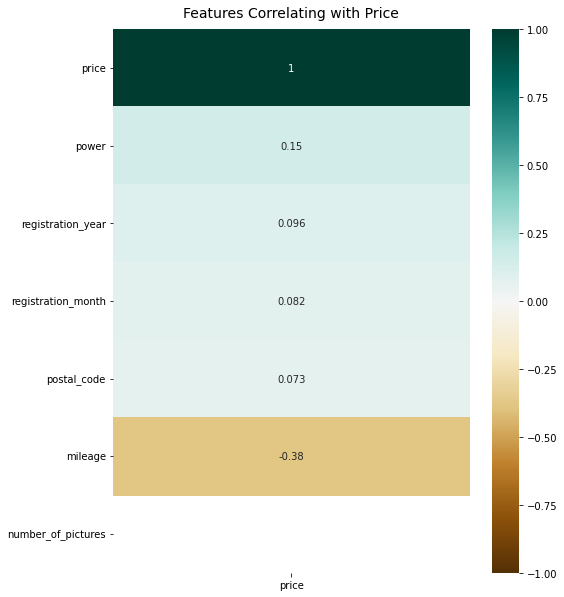

In [26]:
# Correlation of features with price
plt.figure(figsize=(8, 10))

heatmap = sns.heatmap(df.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':14}, pad=12);

The correlation matrix shows there is little to no correlation between price and the selected features. 

Text(0, 0.5, 'frquency')

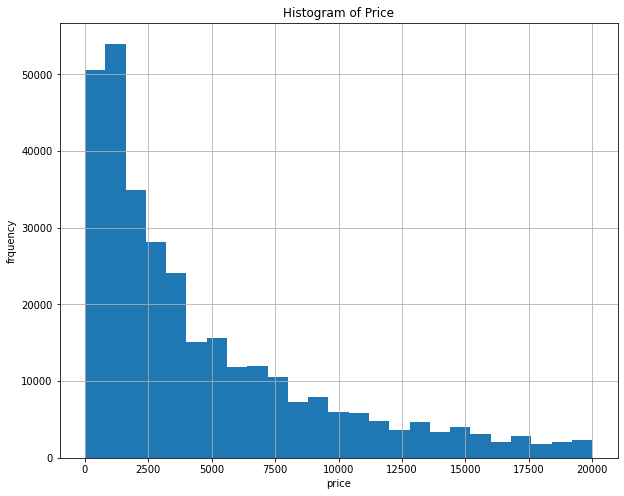

In [27]:
# Histogram of price
df['price'].hist(bins=25, figsize=(10,8))

# Adding title and axes label
plt.title('Histogram of Price')
plt.xlabel('price')
plt.ylabel('frquency')


The distribution of `price` is skewed to the right with most values clustered on the left. Most cars are priced between 0 and 8000 euro.

Text(0.5, 0, 'power')

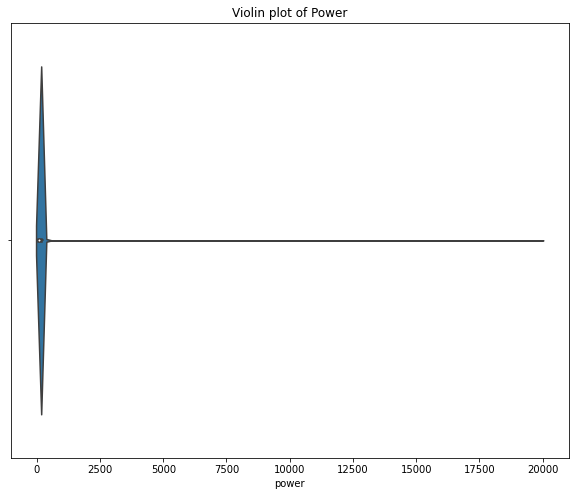

In [28]:
# Violin plot of power
plt.figure(figsize=(10,8))
sns.violinplot(x=df['power'])

# Adding title and axes label
plt.title('Violin plot of Power')
plt.xlabel('power')

A violin plot is a combination of a boxplot and kernel density estimate. It shows the distribution of quantitative data. From our violin plot of `power`, we can see that there are outliers, and that most of our values are clustered way below 2000 hp. 

Text(0.5, 0, 'power')

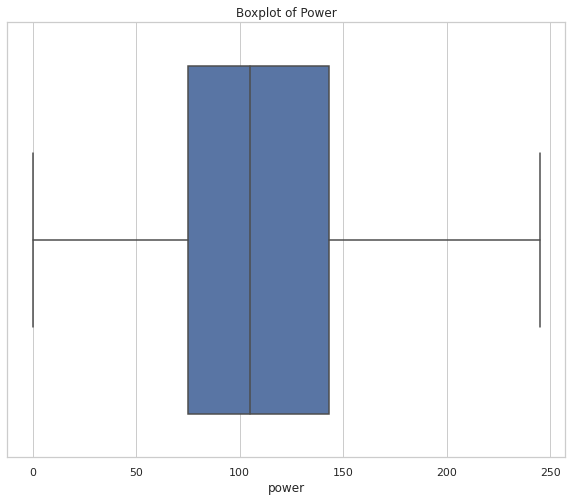

In [29]:
# Boxplot of power without outliers
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(x=df['power'], showfliers=False)

# Adding title and axes label
plt.title('Boxplot of Power')
plt.xlabel('power')

The boxplot of `power` without outliers show that most values are between 0 and 250 hp. 

Text(0, 0.5, 'frquency')

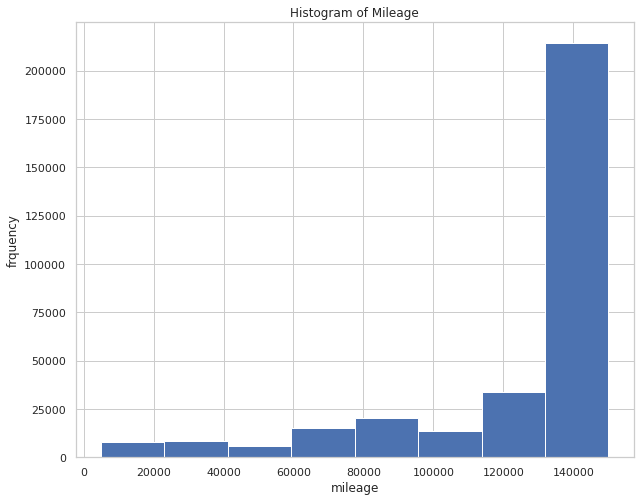

In [30]:
# Histogram of mileage
df['mileage'].hist(bins=8, figsize=(10,8))

# Adding title and axes label
plt.title('Histogram of Mileage')
plt.xlabel('mileage')
plt.ylabel('frquency')

The distribution of `mileage` is skewed to the left with most values clustered to the right. Most cars posted have over 80,000 mileage.

Text(0.5, 0, 'year')

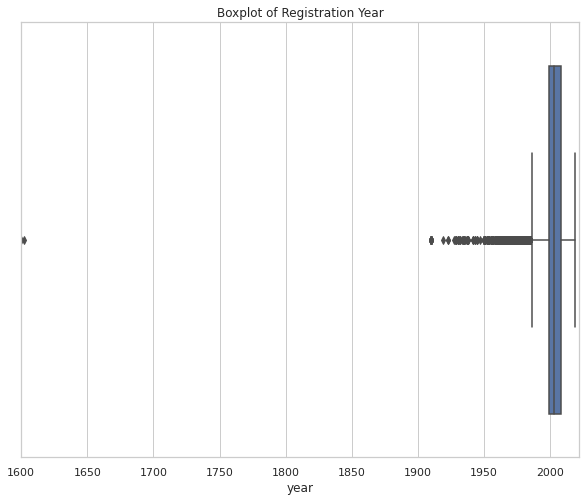

In [31]:
# Boxplot of registration_year
plt.figure(figsize=(10,8))
sns.set_theme(style="whitegrid")
sns.boxplot(x=df['registration_year'])

# Adding title and axes label
plt.xlim(1600,2022)
plt.title('Boxplot of Registration Year')
plt.xlabel('year')

From our boxplot of `registration_year`, we can see that there are outliers. Most cars listed have a registration year of 1980 or newer. 

Text(0, 0.5, 'count')

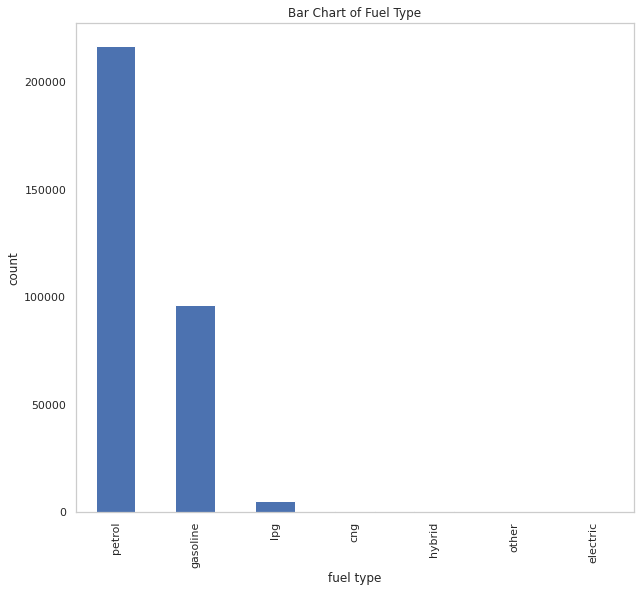

In [32]:
# Bar plot of brand
df['fuel_type'].value_counts().plot(kind = 'bar', figsize=(10,9), grid=False)

# Adding title and axes label
plt.title('Bar Chart of Fuel Type')
plt.xlabel('fuel type')
plt.ylabel('count')

The fuel type for most cars listed is petrol, followed by gasoline and lpg. 

Text(0, 0.5, 'count')

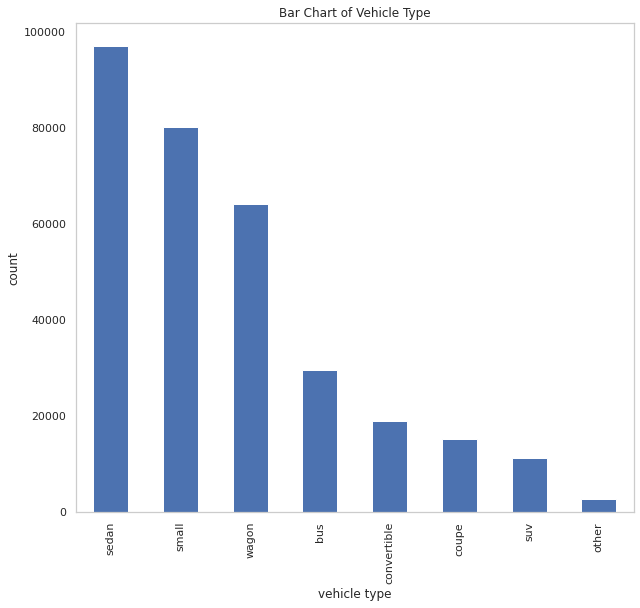

In [33]:
# Bar plot of vehicle type
df['vehicle_type'].value_counts().plot(kind = 'bar', figsize=(10,9), grid=False)

# Adding title and axes label
plt.title('Bar Chart of Vehicle Type')
plt.xlabel('vehicle type')
plt.ylabel('count')

The top three most listed types of cars are sedans, small, and wagons. 

Text(0, 0.5, 'count')

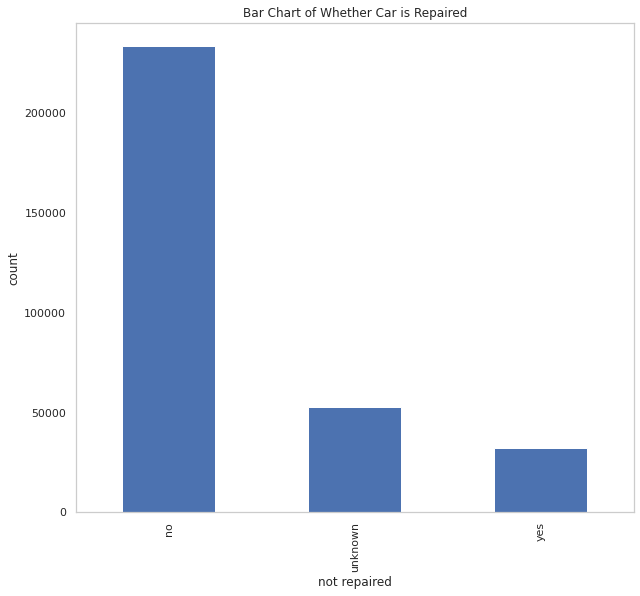

In [34]:
# Bar plot of model
df['not_repaired'].value_counts().plot(kind = 'bar', figsize=(10,9), grid=False)

# Adding title and axes label
plt.title('Bar Chart of Whether Car is Repaired')
plt.xlabel('not repaired')
plt.ylabel('count')

Most cars are not repaired when listed. 

Text(0, 0.5, 'count')

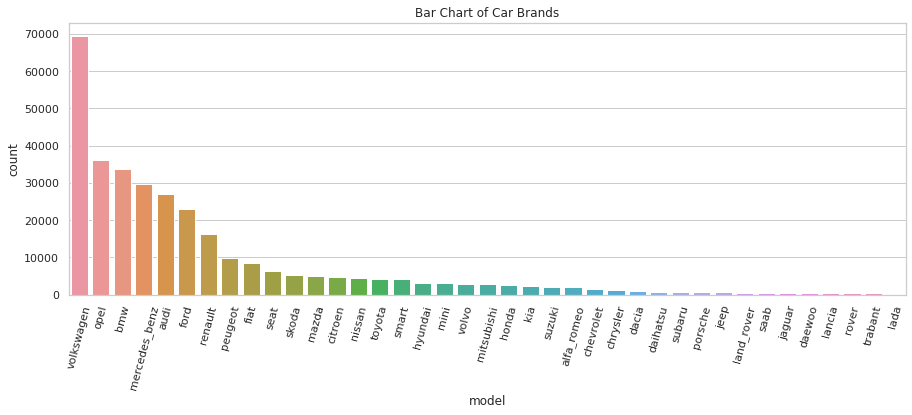

In [35]:
# Top selling vehicle brands
plt.figure(figsize=(15, 5))
highest_brand = df['brand'].value_counts().index
sns.countplot(data=df, x='brand', order=highest_brand)
plt.xticks(rotation=75)
plt.title('Bar Chart of Car Brands')
plt.xlabel('model')
plt.ylabel('count')


From our bar chart of car brands, we can see that Volkswagen, Opel, BMW, Mercedes, and Audi are the top five most listed brands of cars.  

In [36]:
# Filtering out outliers
df_filtered = df[(df['power'] <= 250) & (df['registration_year'] >= 1980) & (df['price'] > 0)]

Since it doesn't make sense for a car to be listed for a price of 0 euros, we filtered out our data for all cars greater than 0. Since most of the cars listed have a horsepower between 0 to 250, we filtered out cars that have greater than 250 hp. Since most cars listed are from the 1980s or newer, we filtered out all older cars. 

In [37]:
# Shape of new filtered data
print('Shape of the filtered dataset:', (df_filtered.shape))

print()

# Getting statistcal summary of filtered data
df_filtered.describe()

Shape of the filtered dataset: (302968, 16)



,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,302968.000000,302968.000000,302968.000000,302968.000000,302968.000000,302968.0,302968.000000
mean,4561.151630,2003.647761,108.189667,128898.811096,5.938462,0.0,50867.517966
std,4434.750407,25.577614,53.185896,36416.893277,3.619520,0.0,25746.715042
min,1.000000,1980.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1250.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30539.000000
50%,2950.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49696.000000
75%,6500.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71397.000000
max,20000.000000,8200.000000,250.000000,150000.000000,12.000000,0.0,99998.000000


### Conclusion

From our exploratory data analysis, we saw that most cars were priced between 0 and 8000 euros. The violin plot of `power` showed that most cars listed have a horsepower below 2000 hp. Removing the outlier from `power` showed that most values were between 0 to 250 hp. A histogram of `mileage` was plotted and we saw that most cars posted have 80,000 miles on it. From the boxplot of `registration_year`, we saw that most cars listed have a registration year of 1980 or newer. The fuel type for most cars listed was petrol, followed by gasoline and lpg. The top three most listed types of cars are sedans, small, and wagons. We also found out that most cars were not repaired before listing. We created a bar chart of car brands, and saw that the top five most popular brands were, Volkswagen, Opel, BMW, Mercedes, and Audi, respectively. 

We filtered out outliers and created a new dataset called `df_filtered`. Our new filtered dataset contains 302968 rows and 16 columns. Now we will train different models with various hyperparameters, and analyze the speed and quality of the models. 


## Training Models

We will train different models with various hyperparameters. Our main goal is to compare gradient boosting methods with random forest, decision tree, and linear regression.

We will analyze the speed and quality of the models using the RMSE metric.

In [38]:
# Dropping unimportant features
cars_df = df_filtered.drop(['date_crawled', 'registration_year', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)

### Linear Regression for Sanity Check

In [39]:
# Defining numerical and categorical features 
numerical = ['mileage', 'power']

categorical = [cname for cname in cars_df.columns if cars_df[cname].dtype in ['object']]

In [40]:
# Creating a standard scaler transformer to scale continuous numerical data
ss = Pipeline(steps=[('ss', StandardScaler())])

# Creating one-hot encoder transformer to encode the categorical data
ohe = Pipeline(steps=[('ohe', OneHotEncoder(drop='first'))])

#Creating preprocess column transformer to combine the ss and ohe pipelines
preprocess = ColumnTransformer(transformers=[('cont', ss, numerical), ('cat', ohe, categorical)])

In [41]:
# Declaring features and target variable
X = cars_df.drop(['price'], axis=1)
y = cars_df['price']

# Splitting data into 75% training set adn 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

In [42]:
%%time

# Creating linear regression pipeline
lr_pipeline = Pipeline(steps=[('preprocess', preprocess), ('linear_regression', LinearRegression())])
lr_pipeline.fit(X_train, y_train)
lr_predict = lr_pipeline.predict(X_test)

# Calculating rmse
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predict))
print('RMSE =', lr_rmse)

RMSE = 2806.6187465674766
CPU times: user 10.2 s, sys: 6.45 s, total: 16.7 s
Wall time: 17.6 s


### Random Forest Regressor

In [43]:
# Splitting data into 75% training set and 25% test set
rfr_X_train, rfr_X_test, rfr_y_train, rfr_y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

# Ordinal encoding
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(rfr_X_train[categorical])
rfr_X_train[categorical] = ordinal_encoder.transform(rfr_X_train[categorical])
rfr_X_test[categorical] = ordinal_encoder.transform(rfr_X_test[categorical])

In [44]:
%%time

# Defining hyperparameters
grid = {'n_estimators':[10,15,20,25], 'max_depth':[6,25,50], 'min_samples_leaf':[1,2,10]}

# Random forest regressor model 
rfr = RandomForestRegressor(random_state=12345)

# Grid search 
grid_search_rfr = GridSearchCV(estimator=rfr, param_grid=grid, scoring='neg_mean_squared_error', cv=5)
grid_search_rfr.fit(rfr_X_train, rfr_y_train)
print('The best hyperparameters are: {}'.format(grid_search_rfr.best_params_))

The best hyperparameters are: {'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 25}
CPU times: user 13min 28s, sys: 3.16 s, total: 13min 31s
Wall time: 13min 38s


In [45]:
%%time

# Creating random forest model with hyperparameters tuned
rfr_model = RandomForestRegressor(**grid_search_rfr.best_params_)
rfr_model.fit(rfr_X_train, rfr_y_train)
rfr_predict = rfr_model.predict(rfr_X_test)

# Calculating RMSE
rfr_rmse = np.sqrt(mean_squared_error(rfr_y_test, rfr_predict))
print('RMSE =', rfr_rmse)

RMSE = 2015.7509524433783
CPU times: user 10.6 s, sys: 29.9 ms, total: 10.6 s
Wall time: 12 s


### LightGBM Regressor

In [46]:
# Splitting data into 75% training set and 25% test set
ltb_X_train, ltb_X_test, ltb_y_train, ltb_y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

# Ordinal encoding
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(ltb_X_train[categorical])
ltb_X_train[categorical] = ordinal_encoder.transform(ltb_X_train[categorical])
ltb_X_test[categorical] = ordinal_encoder.transform(ltb_X_test[categorical])

In [47]:
%%time 

# Defining hyperparameters to tune
ltb_grid = {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators':[6,25,50,100], 'num_leaves':[5,20,25,32]}

# LightGBM model
ltb = LGBMRegressor(random_state=12345)

# Grid search
grid_search_ltb = GridSearchCV(estimator=ltb, param_grid=ltb_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_ltb.fit(ltb_X_train, ltb_y_train)
print('The best hyperparameters are: {}'.format(grid_search_ltb.best_params_))


The best hyperparameters are: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 32}
CPU times: user 5min 21s, sys: 2.37 s, total: 5min 23s
Wall time: 2min 52s


In [48]:
%%time

# Creating LightGBM model with hyperparameters tuned
ltb_model = LGBMRegressor(**grid_search_ltb.best_params_)
ltb_model.fit(ltb_X_train, ltb_y_train)
ltb_predict = ltb_model.predict(ltb_X_test)

# Calculating RMSE
ltb_rmse = np.sqrt(mean_squared_error(ltb_y_test, ltb_predict))
print('RMSE =', ltb_rmse)

RMSE = 2273.976545895668
CPU times: user 3.44 s, sys: 30.9 ms, total: 3.47 s
Wall time: 1.85 s


### CatBoost Regressor

In [49]:
# Splitting data into 75% training set and 25% test set
cat_X_train, cat_X_test, cat_y_train, cat_y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [50]:
%%time

# Defining hyperparameters to tune
cat_grid = {'learning_rate': [0.01, 0.1], 'depth':[3,7,9], 'l2_leaf_reg':[1,5]}

# CatBoost model
cat = CatBoostRegressor(iterations=100, cat_features=cat_features, logging_level='Silent', loss_function='RMSE', early_stopping_rounds=55, random_state=12345)

# Grid search
grid_search_cat = GridSearchCV(estimator=cat, param_grid=cat_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_cat.fit(cat_X_train, cat_y_train)
print('The best hyperparameters are: {}'.format(grid_search_cat.best_params_))

The best hyperparameters are: {'depth': 9, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CPU times: user 13min 43s, sys: 12.4 s, total: 13min 56s
Wall time: 7min 23s


In [51]:
%%time

# Creating CatBoost model with hyperparameters tuned
cat_model = CatBoostRegressor(**grid_search_cat.best_params_)
cat_model.fit(cat_X_train, cat_y_train, cat_features=cat_features, eval_set=(cat_X_test, cat_y_test), verbose=False)
cat_predict = cat_model.predict(cat_X_test)

# Calculating RMSE
cat_rmse = np.sqrt(mean_squared_error(cat_y_test, cat_predict))
print('RMSE =', cat_rmse)

RMSE = 1971.1569129556954
CPU times: user 11min 16s, sys: 10.8 s, total: 11min 27s
Wall time: 6min 3s


### XGBoost

In [52]:
# One-hot encoding of categorical features
cars_df_ohe = pd.get_dummies(cars_df, drop_first=True)

# Declaring features and target
X_ohe = cars_df_ohe.drop(['price'], axis=1)
y_ohe = cars_df_ohe['price']

# Splitting data into 75% training set and 25% test set
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y_ohe, test_size=0.25, random_state=12345)

In [53]:
%%time

# Creating XGBoost regressor model
xgb = XGBRegressor(max_depth=3, n_estimators=100, objective='reg:squarederror', booster='gbtree', n_jobs=-1, random_state=12345, learning_rate=0.1)
xgb.fit(X_train_ohe, y_train_ohe)
xgb_predict = xgb.predict(X_test_ohe)

# Calculating RMSE
xgb_rmse = np.sqrt(mean_squared_error(y_test_ohe, xgb_predict))
print('RMSE =', xgb_rmse)

RMSE = 2544.236325307813
CPU times: user 3min 31s, sys: 1.06 s, total: 3min 32s
Wall time: 1min 50s


### Conclusion

Since linear regression is not great for hyperparameter tuning, we used it as a sanity check for other methods. The metric used to evaluate the models was the root mean squared error (RMSE). The RMSE is the standard deviation of the residuals (or prediction errors). In other words, it tells us how concentrated the data is around the line of best fit. Lower values of RMSE tend to indicate a better fit. The RMSE score for our linear regression model was 2806.62. We used GridSearchCV to perform an exhaustive search over specified parameter values to tune our hyperparameters for a random forest regressor, LightGBM regressor, and CatBoost regressor. After finding the best hyperparameters to use for each model, we fitted our models and calculated the RMSE. For the random forest regressor, we obtained a RMSE score of 2015.75. The LightGBM obtained a RMSE score of 2273.98. The CatBoost Regressor obtained a RMSE score of 1971.16. We also trained a XGBoost regressor model and obtained a RMSE score of 2544.24. 


## Model Analysis

In [76]:
# Creating dataframe to compare diffent performance of models 
model = ['LinearRegressor', 'RandomForestRegressor', 'LightGBM', 'CatBoost', 'XGBoost']
rmse = [2806.62, 2014.84, 2273.98, 1971.16, 2544.24]
tune_time = [0, 888, 200, 420, 0]
model_time = [8.14, 12.6, 15.5, 351, 137]
models = pd.DataFrame(data = zip(model, rmse, tune_time, model_time), columns = ['model', 'rmse_score', 'hyperparameter_tuning_time', 'model_run_time'])

display(models)


,model,rmse_score,hyperparameter_tuning_time,model_run_time
0,LinearRegressor,2806.62,0,8.14
1,RandomForestRegressor,2014.84,888,12.60
2,LightGBM,2273.98,200,15.50
3,CatBoost,1971.16,420,351.00
4,XGBoost,2544.24,0,137.00


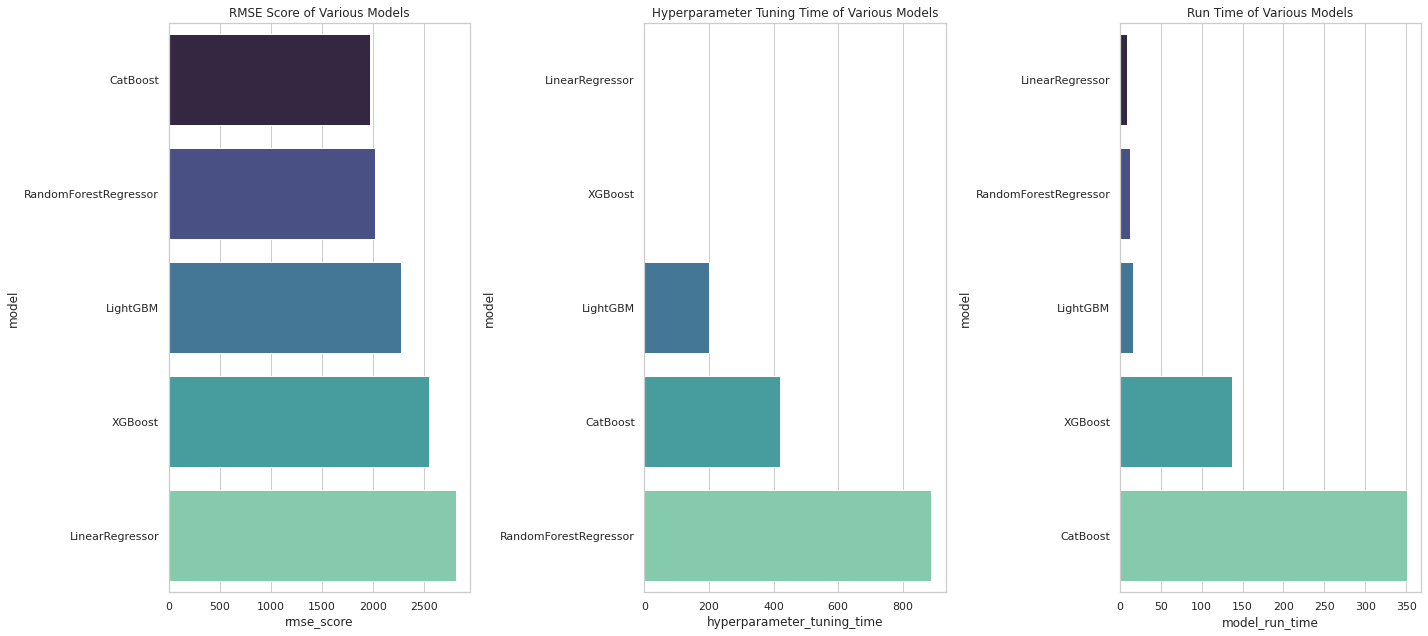

In [89]:
# Plotting performance metrics
sns.set_style('whitegrid')

fig, ax = plt.subplots(1, 3, figsize=(20,9))

sns.barplot(data = models.sort_values('rmse_score'), 
            y = 'model',
            x = 'rmse_score',
            orient = 'h', 
            palette ='mako', 
            ax=ax[0])
ax[0].set_title('RMSE Score of Various Models')

sns.barplot(data = models.sort_values('hyperparameter_tuning_time'), 
            y = 'model',
            x = 'hyperparameter_tuning_time',
            orient = 'h',
            palette = 'mako', 
            ax = ax[1])
ax[1].set_title('Hyperparameter Tuning Time of Various Models')

sns.barplot(data=models.sort_values(by='model_run_time'),
            y ='model',
            x = 'model_run_time', 
            orient = 'h', 
            palette = 'mako', 
            ax = ax[2])
ax[2].set_title('Run Time of Various Models')

plt.tight_layout()
plt.show()

### Conclusion

Our linear regression model had the highest RMSE score of 2806.62, while our CatBoost regressor model had the lowest RMSE score of 1971.16. Our random forest regressor model took the longest to tune hyperparameters using GridSearchCV, while the LightGBM model took the least time. Although our random forest regressor model took the longest to tune hyperparameters, it also took the least time to predict the target. Since the metric used to evaluate our models was RMSE, the CatBoost regressor outperformed the other models. It obtained a significantly lower RMSE score than the other models. 

## Findings

From our exploratory data analysis, we found that most cars were priced between 0 to 8000 euros. Our violin plot of `power` showed that our data was significantly skewed to the right with most values being clustered way below 2000 horsepower (hp). Upon removing our outliers in `power`, we saw that most cars listed had a horsepower between 0 to 250 hp. The histogram of `mileage` showed that most cars posted had at least 80k miles on it. The boxplot of `registration_year` showed that most cars that were listed were from the year 1980 or newer. We observed that most cars listed had a fuel type of petrol, followed by gasoline and lpg. The top three most listed types of cars were sedans, small cars, and wagons. We found out that most cars were not repaired before listing. Upon creating a bar chart of car brands, we found that the top five most popular brands were, Volkswagen, Opel, BMW, Mercedes, and Audi, respectively. Before training our models, we removed outliers and created a new dataset. 

Since linear regression is not great for hyperparameter tuning, we used it as a sanity check for other methods. The metric used to evaluate the models was the root mean squared error (RMSE). Lower values of RMSE tend to indicate a better fit. The RMSE score for our linear regression model was 2806.62. Using a GridSearchCV, we performed an exhaustive search over specified parameter values to tune our hyperparameters for a random forest regressor, LightGBM regressor, and CatBoost regressor. After finding the best hyperparameters to use for each model, we fitted our models and calculated the RMSE
* For the random forest regressor, we obtained a RMSE score of 2015.75
* The LightGBM obtained a RMSE score of 2273.98. 
* The CatBoost Regressor obtained a RMSE score of 1971.16. 

We also trained a XGBoost regressor model and obtained a RMSE score of 2544.24. 

We analyzed the speed and quality of the models we trained. 
* Our linear regression model had the highest RMSE score of 2806.62, while our CatBoost regressor model had the lowest RMSE score of 1971.16. 
* Our random forest regressor model took the longest to tune hyperparameters using GridSearchCV, while the LightGBM model took the least time. 
* Our random forest regressor model took the longest to tune hyperparameters, but also took the least time to predict the target

Since the metric used to evaluate our models was RMSE, the CatBoost regressor outperformed the other models. It obtained a significantly lower RMSE score than the other models. A summary of the models we trained is summarized below:

| Model | RMSE Score | Hyperparameter Tuning Time (sec) | Model Run Time (sec) |
| --- | --- | --- | ---|
| Linear Regressor | 2806.62 | N/A | 8.14 s |
| Random Forest Regressor | 2014.84 | 888 s | 12.6 s
| LightGBM | 2273.98 | 200 s | 15.5 s 
| CatBoost | 1971.16 | 420 s | 351 s
| XGBoost | 2544.24 | N/A | 137 s
